In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'ieee'])
torch.manual_seed(1024)

k = 400 # spring constant
c = 4 # damping constant
m = 1 # load mass
# F = 0 # external force

def exact_function(t):
    d = c / (2 * m)
    w0 = np.sqrt(k / m)

    # x(t) = exp^(-d * t) * (2A * cos(phi + w * t))
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1 / (2 * np.cos(phi))
    x = (np.exp(-d * t)) * (2 * A * np.cos(phi + w * t))
    return x

# DATA PROCESSING
# boundary timeline
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)

# physics timeline
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

# dataset train/test
t_train = torch.linspace(0, 0.25, 30).view(-1, 1).requires_grad_(True)
x_train = torch.tensor(exact_function(t_train.detach().numpy())).view(-1, 1).requires_grad_(True)
t_test = torch.linspace(0, 1, 1200).view(-1, 1).requires_grad_(True)
x_test = torch.tensor(exact_function(t_test.detach().numpy())).view(-1, 1).requires_grad_(True)

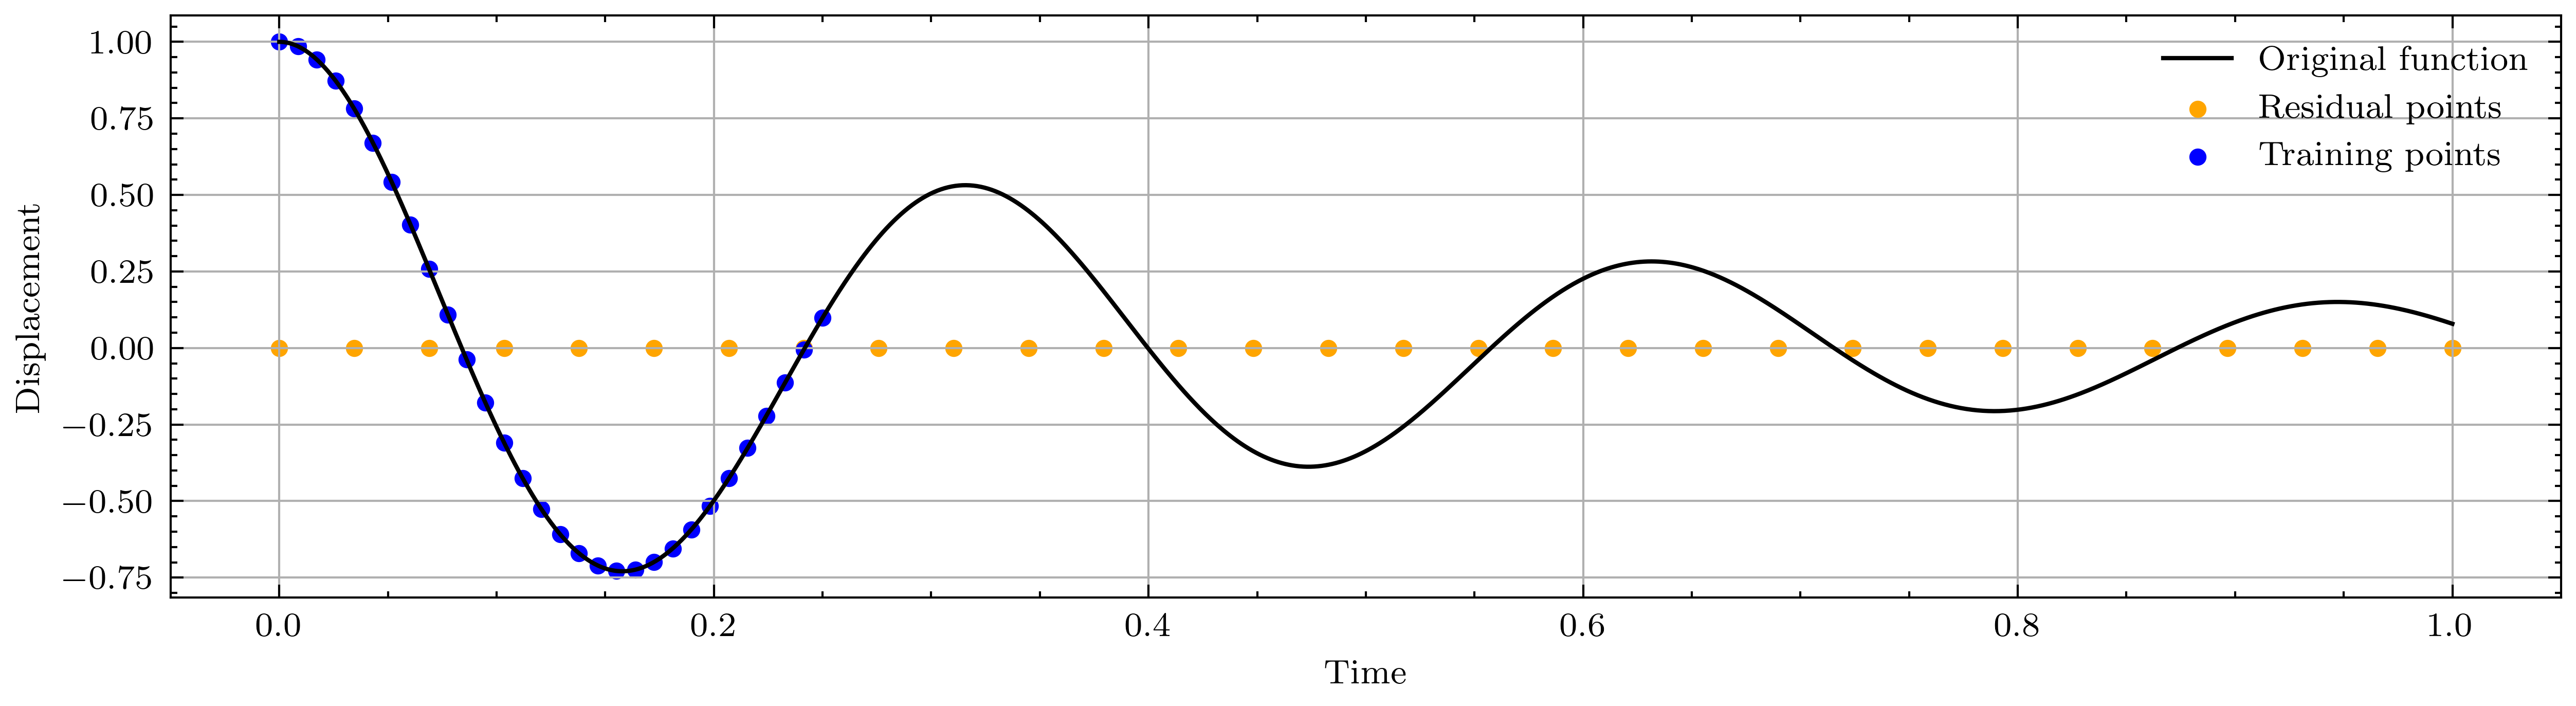

In [5]:
# Plot the original function and the predicted function
fig, ax = plt.subplots(figsize=(10, 2.5))
ax.plot(t_test.detach().numpy(), x_test.detach().numpy(), label='Original function')
ax.scatter(t_physics.detach().numpy(), torch.zeros_like(t_physics).detach().numpy(), label='Residual points', color='orange', marker='.')
ax.scatter(t_train.detach().numpy(), x_train.detach().numpy(), label='Training points', color='blue', marker='.')
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
plt.grid()
plt.legend()
plt.savefig("../figures/problem_statement.svg", format='svg', dpi=300, bbox_inches='tight')
plt.show()

In [3]:
# Define the neural network model
class FCNN(nn.Module):
    '''
    Define neural network architecture
    '''
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN), activation()
        ])
        
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_HIDDEN, N_HIDDEN), activation()
            ]) for _ in range(N_LAYERS)
        ])
        
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


def loss_calc(model, criterion):
    # loss weights
    lam1, lam2 = 1e-1, 1e-4

    # general loss
    x_pred = model(t_train)
    loss1 = criterion(x_pred, x_train)

    # boundary loss
    x_pred = model(t_boundary)
    loss2 = criterion(x_pred, torch.ones_like(x_pred))
    dxdt = torch.autograd.grad(x_pred, t_boundary, torch.ones_like(x_pred), create_graph=True)[0]
    loss3 = criterion(dxdt, torch.zeros_like(dxdt))

    # physics loss
    x_pred = model(t_physics)
    dxdt = torch.autograd.grad(x_pred, t_physics, torch.ones_like(x_pred), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(dxdt, t_physics, torch.ones_like(dxdt), create_graph=True)[0]
    h = (m * d2xdt2 + c * dxdt + k * x_pred)
    loss4 = criterion(h, torch.zeros_like(h))

    final_loss = loss2 + lam1 * loss3 + lam2 * loss4
    
    return final_loss


In [4]:
model = FCNN(1, 1, 32, 8)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the neural network
loss_curve = {
    "epoch": [],
    "loss": [],
}
num_epochs = 15_000
for epoch in range(num_epochs):
    model.train()
    
    optimizer.zero_grad()

    loss = loss_calc(model, criterion)
    loss.backward()
    optimizer.step()

    loss_curve["epoch"].append(epoch)
    loss_curve["loss"].append(loss.item())

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')

model_path = f"../src/model/model_pinn.pt"
torch.save(model.state_dict(), model_path)
print("model saved!")

# model.load_state_dict(torch.load(model_path))
model.eval()
predictions = model(t_test)


Epoch [100/15000], Loss: 0.44186249
Epoch [200/15000], Loss: 0.23473129
Epoch [300/15000], Loss: 0.19036406
Epoch [400/15000], Loss: 0.14382821
Epoch [500/15000], Loss: 0.13406894
Epoch [600/15000], Loss: 0.11303957
Epoch [700/15000], Loss: 0.09813740
Epoch [800/15000], Loss: 0.08914608
Epoch [900/15000], Loss: 0.06599845
Epoch [1000/15000], Loss: 0.05422460
Epoch [1100/15000], Loss: 0.05299430
Epoch [1200/15000], Loss: 0.05348403
Epoch [1300/15000], Loss: 0.04973319
Epoch [1400/15000], Loss: 0.05692733
Epoch [1500/15000], Loss: 0.04674974
Epoch [1600/15000], Loss: 0.04468857
Epoch [1700/15000], Loss: 0.04582009
Epoch [1800/15000], Loss: 0.04558724
Epoch [1900/15000], Loss: 0.12331814
Epoch [2000/15000], Loss: 0.04414973
Epoch [2100/15000], Loss: 0.03974243
Epoch [2200/15000], Loss: 0.04298894
Epoch [2300/15000], Loss: 0.03760080
Epoch [2400/15000], Loss: 0.03793006
Epoch [2500/15000], Loss: 0.04561364
Epoch [2600/15000], Loss: 0.03308431
Epoch [2700/15000], Loss: 0.02884991
Epoch [280

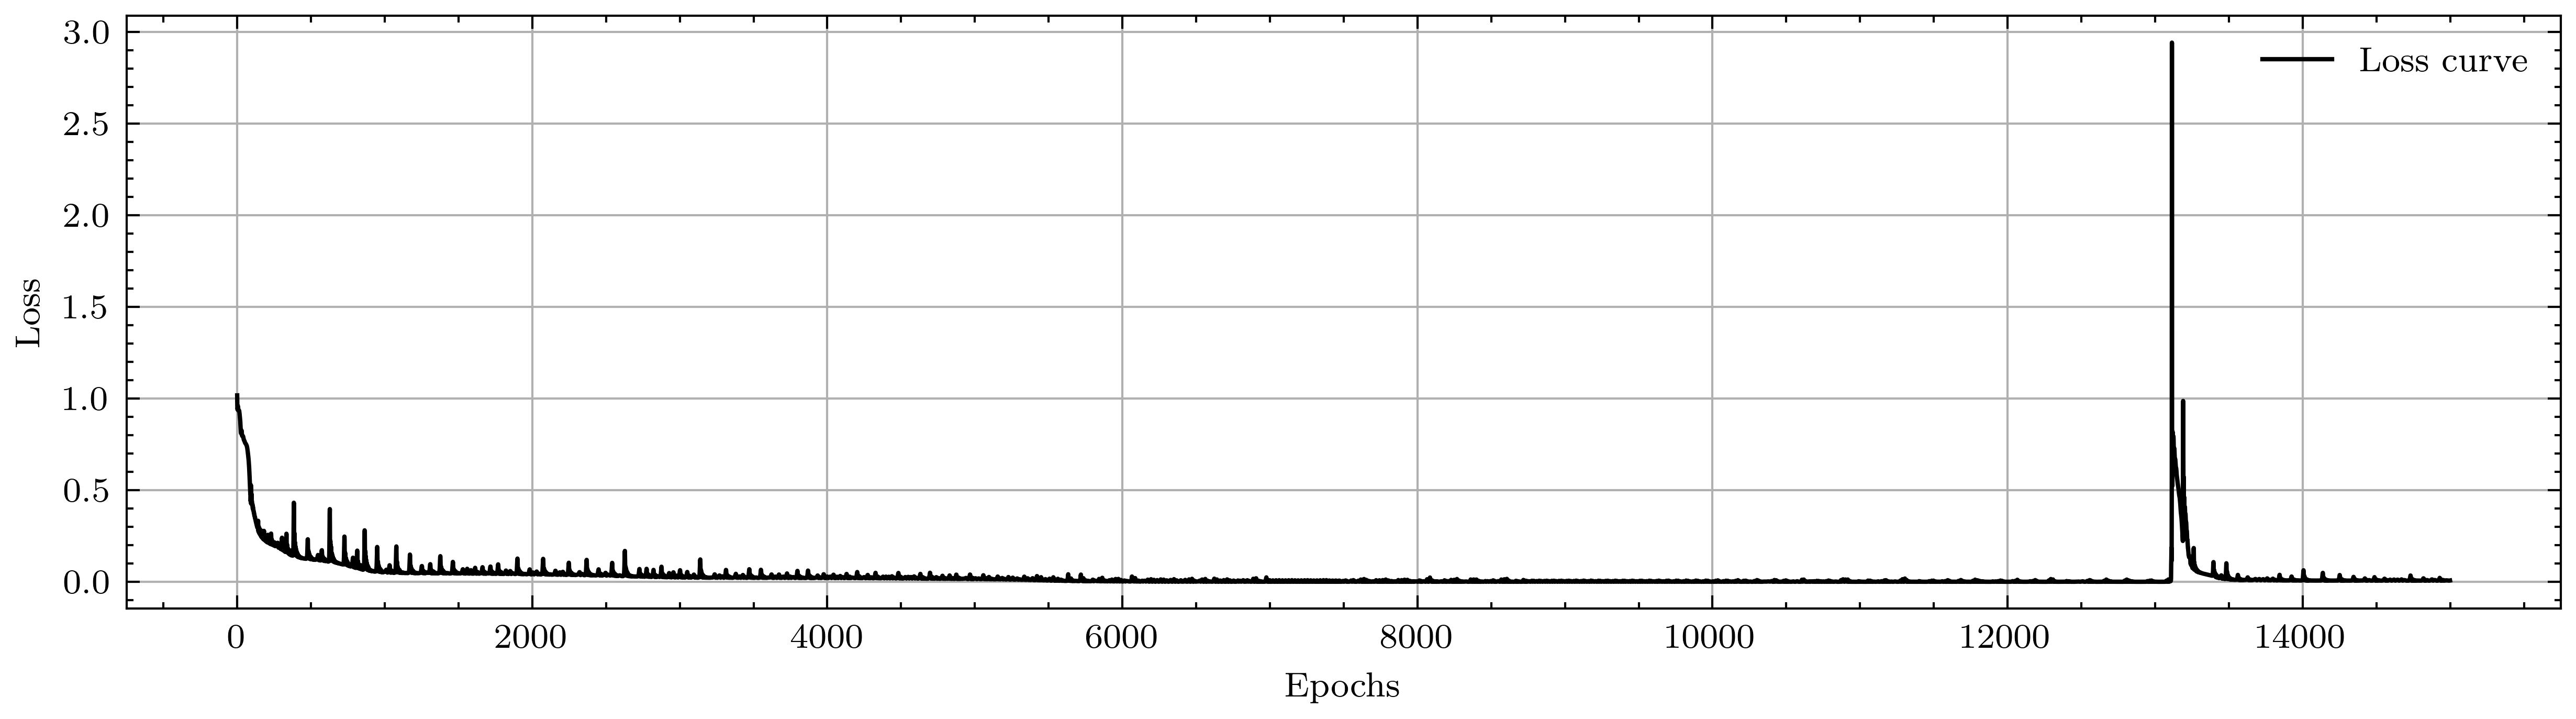

In [5]:
# Plot the loss curve
fig, ax = plt.subplots(figsize=(10, 2.5))
ax.plot(loss_curve['epoch'], loss_curve['loss'], label='Loss curve')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

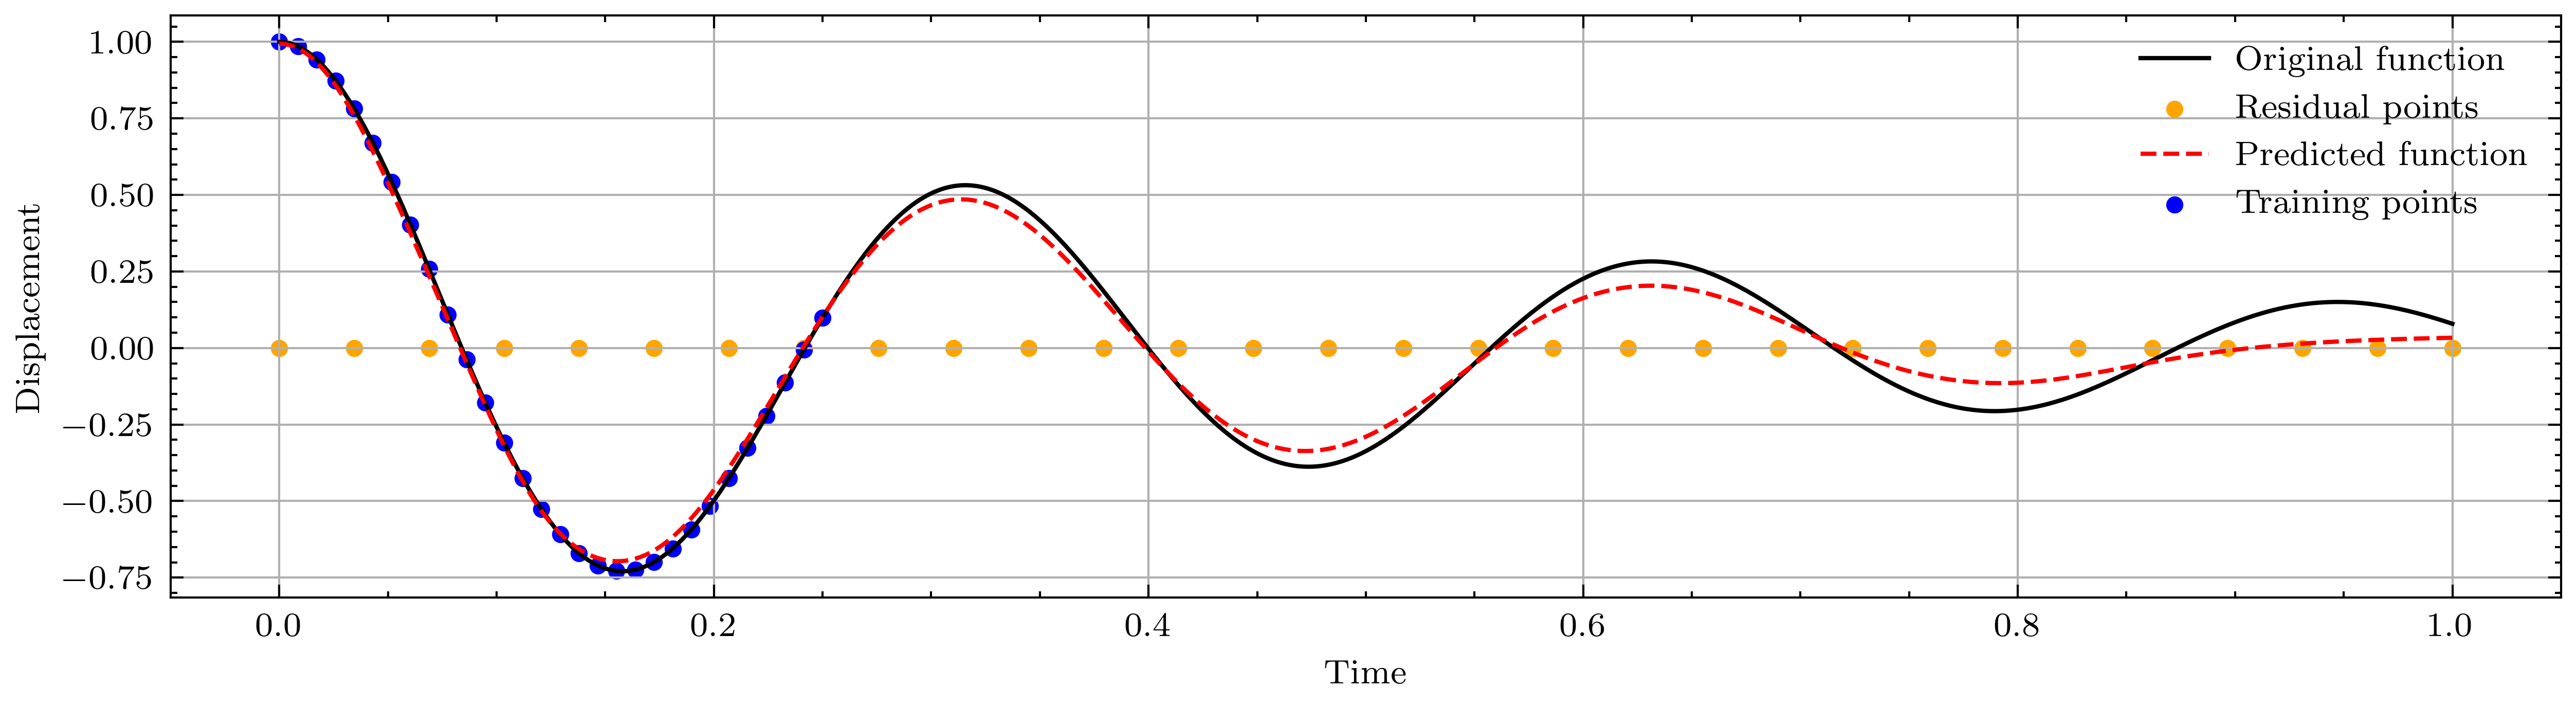

In [6]:
# Plot the original function and the predicted function
fig, ax = plt.subplots(figsize=(10, 2.5))
ax.plot(t_test.detach().numpy(), x_test.detach().numpy(), label='Original function')
ax.scatter(t_physics.detach().numpy(), torch.zeros_like(t_physics).detach().numpy(), label='Residual points', color='orange', marker='.')
ax.plot(t_test.detach().numpy(), predictions.detach().numpy(), label='Predicted function', color='red')
ax.scatter(t_train.detach().numpy(), x_train.detach().numpy(), label='Training points', color='blue', marker='.')
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
plt.grid()
plt.legend()
plt.show()